In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Groundwater data
data = {
    'Year': [2023, 2022, 2020, 2017, 2013, 2011, 2009],
    'Annual_Groundwater_Recharge': [18.93, 17.74, 18.16, 16.84, 17.00, 17.03, 16.81],
    'Annual_Extractable_Groundwater_Resource': [17.08, 16.04, 16.40, 14.79, 14.83, 14.81, 14.81],
    'Current_Annual_Groundwater_Extraction': [11.32, 11.22, 10.63, 10.34, 9.76, 9.41, 10.01],
}

df = pd.DataFrame(data)
df = df.sort_values(by='Year').reset_index(drop=True)  # Ensure the data is sorted by year

# Preprocessing
df['Year'] = pd.to_datetime(df['Year'], format='%Y')
df.set_index('Year', inplace=True)

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# Create sequences for LSTM
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length][2]  # Current Annual Groundwater Extraction
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

SEQ_LENGTH = 3  # 3 years of past data to predict the next year's groundwater extraction
X, y = create_sequences(scaled_data, SEQ_LENGTH)

# Split data into training and testing sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Build the LSTM model
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(SEQ_LENGTH, 3)))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=50, batch_size=2, validation_split=0.2, callbacks=[early_stopping])

# Evaluate the model
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(np.concatenate((np.zeros((predictions.shape[0], 2)), predictions), axis=1))[:, 2]
y_test_inv = scaler.inverse_transform(np.concatenate((np.zeros((y_test.shape[0], 2)), y_test.reshape(-1, 1)), axis=1))[:, 2]

# Prepare data for plotting
train_predictions = model.predict(X_train)
train_predictions = scaler.inverse_transform(np.concatenate((np.zeros((train_predictions.shape[0], 2)), train_predictions), axis=1))[:, 2]
y_train_inv = scaler.inverse_transform(np.concatenate((np.zeros((y_train.shape[0], 2)), y_train.reshape(-1, 1)), axis=1))[:, 2]

# Predict future values for 10 years
future_years = 10
future_predictions = []
last_sequence = scaled_data[-SEQ_LENGTH:]  # Last available sequence from the data

for _ in range(future_years):
    next_pred = model.predict(last_sequence[np.newaxis, :, :])[0, 0]
    future_predictions.append(next_pred)
    last_sequence = np.append(last_sequence[1:], [[last_sequence[-1, 0], last_sequence[-1, 1], next_pred]], axis=0)

future_predictions = scaler.inverse_transform(np.concatenate((np.zeros((len(future_predictions), 2)), np.array(future_predictions).reshape(-1, 1)), axis=1))[:, 2]

# Find the year when the groundwater extraction level rises
def find_rise_year(predictions, actual_index):
    for i in range(1, len(predictions)):
        if predictions[i] > predictions[i - 1]:
            return actual_index[i].year
    return None

rise_year = find_rise_year(predictions, df.index[-len(y_test):])

Epoch 1/50
1/1 [==============================] - 8s 8s/step - loss: 0.3186 - val_loss: 0.8731
Epoch 2/50
1/1 [==============================] - 0s 57ms/step - loss: 0.3118 - val_loss: 0.8453
Epoch 3/50
1/1 [==============================] - 0s 58ms/step - loss: 0.2990 - val_loss: 0.8181
Epoch 4/50
1/1 [==============================] - 0s 58ms/step - loss: 0.2846 - val_loss: 0.7907
Epoch 5/50
1/1 [==============================] - 0s 78ms/step - loss: 0.2757 - val_loss: 0.7628
Epoch 6/50
1/1 [==============================] - 0s 62ms/step - loss: 0.2604 - val_loss: 0.7340
Epoch 7/50
1/1 [==============================] - 0s 66ms/step - loss: 0.2431 - val_loss: 0.7042
Epoch 8/50
1/1 [==============================] - 0s 61ms/step - loss: 0.2352 - val_loss: 0.6735
Epoch 9/50
1/1 [==============================] - 0s 64ms/step - loss: 0.2346 - val_loss: 0.6419
Epoch 10/50
1/1 [==============================] - 0s 53ms/step - loss: 0.2202 - val_loss: 0.6093
Epoch 11/50
1/1 [==============

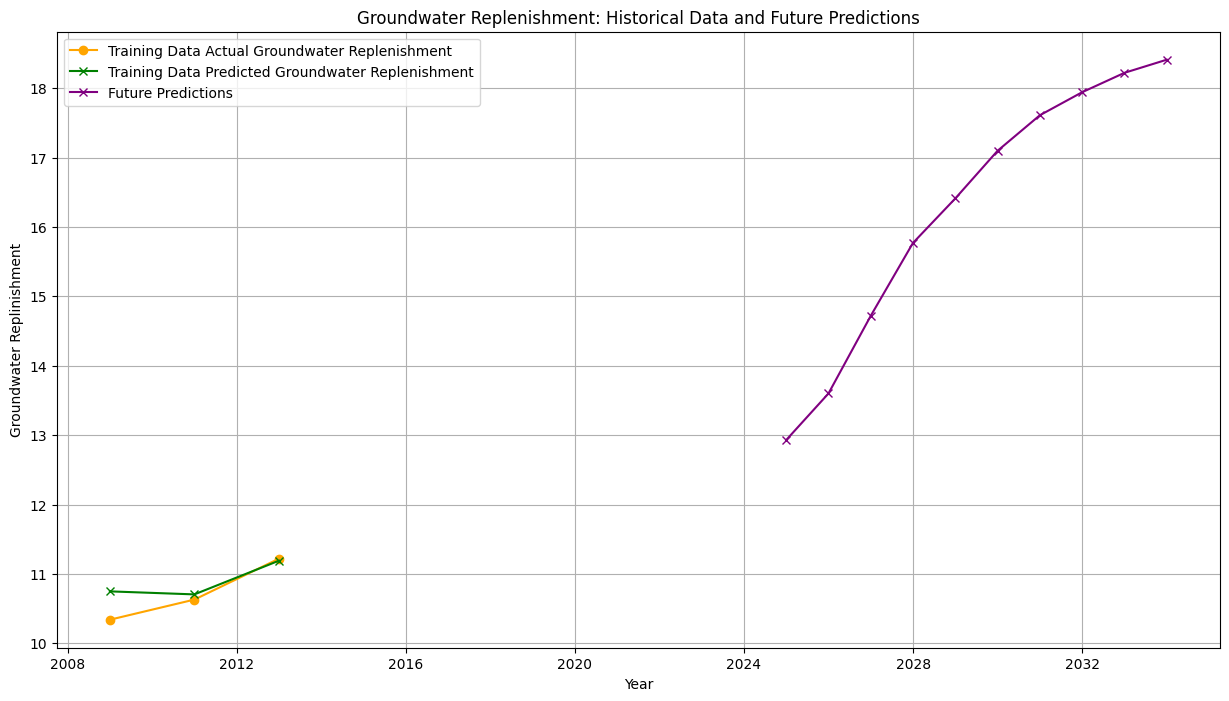

In [ ]:
plt.figure(figsize=(15, 8))
plt.plot(df.index[:len(y_train_inv)], y_train_inv, color='orange', label='Training Data Actual Groundwater Replenishment', marker='o')
plt.plot(df.index[:len(y_train_inv)], train_predictions, color='green', label='Training Data Predicted Groundwater Replenishment', marker='x')
future_index = pd.date_range(start=df.index[-len(y_test):][-1], periods=future_years + 1, freq='Y')[1:]
plt.plot(future_index, future_predictions, color='purple', label='Future Predictions', marker='x')

# Add titles and labels
plt.title('Groundwater Replenishment: Historical Data and Future Predictions')
plt.xlabel('Year')
plt.ylabel('Groundwater Replinishment')
plt.legend()
plt.grid(True)
plt.show()